### **Keypoint Detection**

### Sift

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

TEST_IMG = "test.jpeg"

In [37]:
def split_img(img, rows, cols, split_size, draw_splits=True):
    splits = []
    m_size, n_size = img.shape[0], img.shape[1]
    remain_r, remain_c = m_size % rows, n_size % cols

    for j in range(cols):
        f_j, l_j = j == 0, j == cols - 1
        start_j = j * (n_size // cols) - (not f_j) * split_size
        end_j = (j + 1) * (n_size // cols) + (not l_j) * split_size

        if not f_j:
            cv.line(
                img, (start_j, 0), (start_j, len(img)), (0,0,255), 2
            )
        if not l_j:
            cv.line(
                img, (end_j, 0), (end_j, len(img)), (0,0,255), 2
            )

    for i in range(rows):
        row = []
        f_i, l_i = i == 0, i == cols - 1
        start_i = i * (m_size // rows) - (not f_i) * split_size
        end_i = (i + 1) * (m_size // rows) + (not l_i) * split_size

        if not f_i:
            cv.line(
                img, (0, start_i), (n_size, start_i), (0,0,255), 2
            )
        if not l_i:
            cv.line(
                img, (0, end_i), (n_size, end_i), (0,0,255), 2
            )

    for i in range(rows):
        row = []
        f_i, l_i = i == 0, i == cols - 1
        start_i = i * (m_size // rows) - (not f_i) * split_size
        end_i = (i + 1) * (m_size // rows) + (not l_i) * split_size

        for j in range(cols):
            f_j, l_j = j == 0, j == cols - 1
            start_j = j * (n_size // cols) - (not f_j) * split_size
            end_j = (j + 1) * (n_size // cols) + (not l_j) * split_size

            row.append(
                img[
                    start_i:end_i + l_i * remain_r,
                    start_j:end_j + l_j * remain_c,
                ] if img.ndim == 2 else 
                img[
                    start_i:end_i + l_i * remain_r,
                    start_j:end_j + l_j * remain_c,
                    ::-1
                ]
            )
            
        splits.append(row)
            
    return splits

In [38]:
# need to reverse channel order for rgb
def show_splits(splits, title=None, **kwargs):
    rows = len(splits)
    cols = len(splits[0])
    
    fig, axes = plt.subplots(
        rows, cols, sharex=True, sharey=True, figsize=(20,10)
    )

    if rows == 1 and cols == 1:
        axes.imshow(splits[0][0], **kwargs)
        if title:
            axes.set_title(title)
        return

    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                axes[j].imshow(splits[i][j], **kwargs)
                axes[j].set_title(f"Split {j}")
            else:
                axes[i, j].imshow(splits[i][j], **kwargs)
                axes[i, j].set_title(f"Split {i}, {j}")

# show_splits(splits, cmap='gray')
# plt.figure(figsize = (20,10))
# plt.imshow(splits[0][0], cmap='gray')

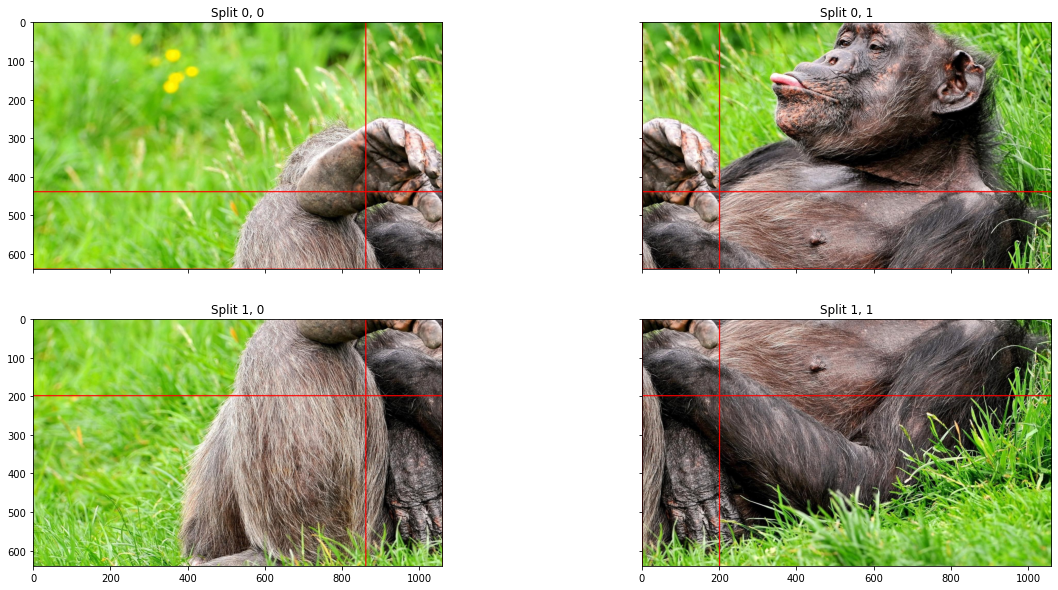

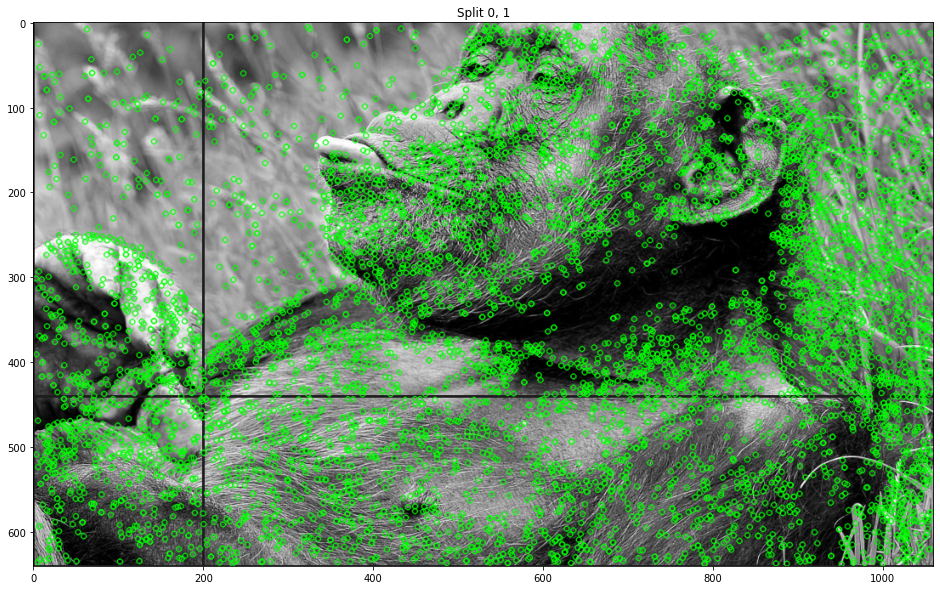

In [43]:
src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
sift = cv.SIFT_create()
r_split, c_split, split_size = 2, 2, 100
splits = split_img(img, r_split, c_split, split_size)

sample_split = splits[0][1]
sample_split = cv.cvtColor(sample_split, cv.COLOR_BGR2GRAY)
keypoints = sift.detect(sample_split)
sample_split = cv.drawKeypoints(sample_split, keypoints, img, color = (0, 255, 0))

show_splits(splits)
show_splits([[sample_split]], title="Split 0, 1", cmap='gray')

In [6]:
## Show that it is invariant

## randomly change images try to stitch